In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import pudl
import pandas as pd
import numpy as np
import sqlalchemy as sa
import pudl.output.eia923 as eia
from pudl.workspace.setup import PudlPaths
pudl_engine = sa.create_engine(PudlPaths().pudl_db)


In [12]:
api_df = eia.get_fuel_cost_avg_eiaapi(eia.FUEL_COST_CATEGORIES_EIAAPI) # coal, oil, gas

In [43]:
bulk_df = eia.get_fuel_cost_avg_bulk_elec(pudl_engine=pudl_engine)

In [12]:
bulk_df.head()

,state,report_date,bulk_agg_fuel_cost_per_mmbtu,fuel_type_code_pudl
0,AK,2012-01-01,0.0,coal
1,AK,2012-02-01,0.0,coal
2,AK,2012-03-01,0.0,coal
3,AK,2012-04-01,0.0,coal
4,AK,2012-05-01,0.0,coal


In [13]:
api_df.drop(columns=['name', 'series_id', 'units']).head()

,report_date,fuel_cost_per_unit,state,fuel_type_code_pudl
0,2022-07-01,51.83,AK,coal
1,2022-06-01,59.16,AK,coal
2,2022-05-01,53.04,AK,coal
3,2022-04-01,51.69,AK,coal
4,2022-03-01,58.55,AK,coal


In [14]:
bulk_df.shape, api_df.shape

((18501, 4), (30804, 7))

In [15]:
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18501 entries, 0 to 18500
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   state                         18501 non-null  object        
 1   report_date                   18501 non-null  datetime64[ns]
 2   bulk_agg_fuel_cost_per_mmbtu  18501 non-null  float64       
 3   fuel_type_code_pudl           18501 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 578.3+ KB


In [16]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30804 entries, 0 to 10499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   report_date          30804 non-null  datetime64[ns]
 1   fuel_cost_per_unit   18615 non-null  float64       
 2   state                30804 non-null  object        
 3   units                30804 non-null  object        
 4   series_id            30804 non-null  object        
 5   name                 30804 non-null  object        
 6   fuel_type_code_pudl  30804 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.9+ MB


In [19]:
keep_cols = ['state', 'report_date',
'fuel_cost_per_mmbtu', 'fuel_type_code_pudl', 'fuel_cost_from_eiaapi']

In [20]:
frc_api = eia.fuel_receipts_costs_eia923(
    pudl_engine=pudl_engine,
    fill=True
)[keep_cols + ['fuel_cost_per_unit']]

In [6]:
frc_bulk = eia.fuel_receipts_costs_eia923(
    pudl_engine=pudl_engine,
    fill=True
)[keep_cols + ['bulk_agg_fuel_cost_per_mmbtu']]

In [21]:
frc_api.shape, frc_bulk.shape

((560374, 6), (560374, 6))

In [26]:
mismatch = frc_api['fuel_cost_from_eiaapi'] ^ frc_bulk['fuel_cost_from_eiaapi']

In [27]:
mismatch.agg(['sum', 'mean'])

sum     0.0
mean    0.0
Name: fuel_cost_from_eiaapi, dtype: float64

In [21]:
frc_api['fuel_cost_from_eiaapi'].sum()

136530

In [28]:
frc_bulk['fuel_cost_from_eiaapi'].sum()

136530

In [30]:
diff = frc_api['fuel_cost_per_mmbtu'].sub(frc_bulk['fuel_cost_per_mmbtu'])

In [32]:
diff.ne(0).agg(['sum', 'mean'])

sum     186016.00000
mean         0.33195
Name: fuel_cost_per_mmbtu, dtype: float64

In [35]:
diff.abs().gt(1e-3).agg(['sum', 'mean'])

sum     133687.000000
mean         0.238567
Name: fuel_cost_per_mmbtu, dtype: float64

In [34]:
frc_bulk['fuel_cost_from_eiaapi'].agg(['sum', 'mean'])

sum     136530.000000
mean         0.243641
Name: fuel_cost_from_eiaapi, dtype: float64

<AxesSubplot:>

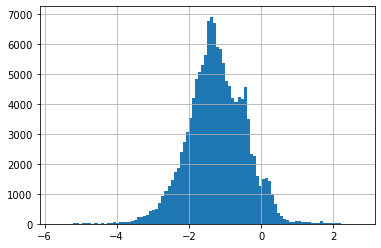

In [37]:
diff.abs().replace(np.inf, np.nan).replace(0, np.nan).transform(np.log10).hist(bins=100)

In [40]:
import matplotlib.pyplot as plt

In [ ]:
# data is all in same order
frc_api.drop(columns=['fuel_cost_per_mmbtu', 'fuel_cost_per_unit']).eq(
    frc_bulk.drop(columns=['fuel_cost_per_mmbtu', 'bulk_agg_fuel_cost_per_mmbtu'])
).all()

state                    True
report_date              True
fuel_type_code_pudl      True
fuel_cost_from_eiaapi    True
dtype: bool

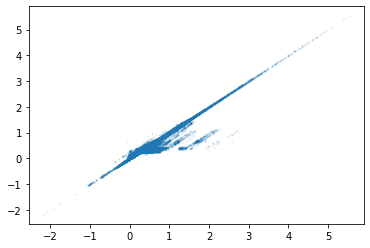

In [42]:
plt.scatter(frc_api['fuel_cost_per_mmbtu'].replace(0, np.nan).transform(np.log10),
frc_bulk['fuel_cost_per_mmbtu'].replace(0, np.nan).transform(np.log10),
s=1, alpha=0.1)